<a href="https://colab.research.google.com/github/ksun0401/musinsa_recommend/blob/master/Grad_CAM%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%9D%98%EB%A5%98_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 의류 이미지 분류와 Grad-CAM을 이용한 영역 모델 해석



In [ ]:
# 한글 폰트 세팅
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torchvision

from torchvision import transforms
import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import re
from tqdm import tqdm

import gc

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score

import warnings  
warnings.filterwarnings(action = 'ignore')

print(A.__version__)
!nvidia-smi

1.2.1
Fri Dec  9 05:21:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [ ]:
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/musinsa_high/musinsa.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53890 entries, 0 to 53889
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    53890 non-null  object
 1   label   53890 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
df.head()

,path,label
0,/content/drive/MyDrive/data/musinsa_high/musin...,0
1,/content/drive/MyDrive/data/musinsa_high/musin...,0
2,/content/drive/MyDrive/data/musinsa_high/musin...,0
3,/content/drive/MyDrive/data/musinsa_high/musin...,0
4,/content/drive/MyDrive/data/musinsa_high/musin...,0


In [ ]:
# 의류 이름 컬럼 생성을 위해 path에서 이름만 추출

def re_h(x):
    x = re.compile('[a-zA-Z0-9/_.]').sub('', x).strip()
    return x

def cut_label(x):
    x = x[:int(len(x)/2)]
    return x

In [ ]:
# 각 label의 개수 확인
# 크게 unbalance하지는 않다.

df['name'] = df['path'].apply(re_h).apply(cut_label)
df['name'].value_counts()

긴팔티               2070
레깅스                2070
후드티                 2070
트레이닝팬츠         2070
플리스                2070
코튼팬츠             2070
코치(나일론)재킷    2070
카라티                 2070
숏패딩               2070
슬랙스               2070
숏팬츠               2070
블루종               2070
블레이저재킷         2070
반팔티               2070
맨투맨               2070
데님팬츠             2070
니트스웨터             2070
기타바지               2070
가디건                2070
후드집업             2070
트러커재킷            2042
기타상의              1945
환절기코트           1803
겨울코트              1721
레더재킷              1674
트레이닝재킷         1313
무스탕                 724
롱패딩                674
바시티재킷             594
Name: name, dtype: int64

In [ ]:
# custom_dataset 생성

class Custom_Dataset(Dataset):
    def __init__(self, x, y = None, transforms = None):
        self.x = x
        self.y = y
        self.transforms = transforms
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):

        img = Image.open(self.x[idx]).convert("RGB") # RGB로 변환
        img = np.array(img)
        label = self.y[idx]

        if self.transforms:
            img = self.transforms(image = img)
            img = img['image']
            
        return img, label

### train-val-test(8:1:1) 나누기
>train: 43112 <br>
>validation: 5389 <br>
>test: 5389 <br>

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['path'], df['label'],
                                                  test_size = 0.2, shuffle = True,
                                                  stratify = df['label'], random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                  test_size = 0.5, shuffle = True,
                                                  stratify = y_test, random_state = 42)

x_train = list(x_train)
x_val = list(x_val)
y_train = list(y_train)
y_val = list(y_val)
x_test = list(x_test)
y_test = list(y_test)

In [ ]:
train_val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

In [ ]:
# train: 43112
# val: 5389
# test: 5389

print(f'x_train: {len(x_train)}, y_train: {len(y_train)}\nx_val: {len(x_val)}, y_val: {len(y_val)}\nx_test: {len(x_test)}, y_test: {len(y_test)}')

x_train: 43112, y_train: 43112
x_val: 5389, y_val: 5389
x_test: 5389, y_test: 5389


In [ ]:
# DataLoader
# 배치 사이즈: 32
# train만 shuffle 허용

train_dataset = Custom_Dataset(x_train, y_train, transforms = train_val_transform)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True, num_workers=6)

val_dataset = Custom_Dataset(x_val, y_val, transforms = train_val_transform)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, drop_last = True, num_workers=6)

test_dataset = Custom_Dataset(x_test, y_test, transforms = test_transform)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, drop_last = True, num_workers=0)

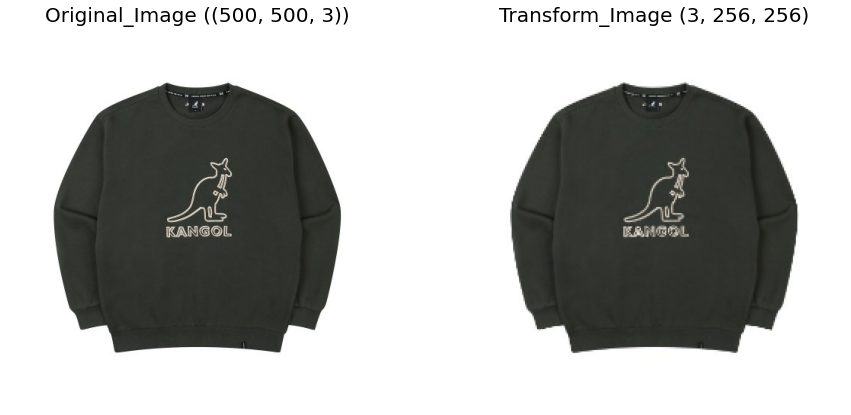

In [ ]:
# 원본 이미지와 transform 된 이미지 비교

fig = plt.figure(figsize=(15, 15))
def custom_imshow(img_transform, img):

    img_transform = img_transform.numpy()
    
    ax1 = fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    ax1.set_title(f'Original_Image ({img.shape})', size = 20)
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(np.transpose(img_transform/255.0, (1, 2, 0))) 
    ax2.set_title('Transform_Image (3, 256, 256)', size = 20)
    ax2.axis("off")
    plt.show()


img = Image.open(df.path[593]).convert('RGB')
img = np.array(img)
img_transform = train_val_transform(image = img)
img_transform = img_transform['image']

custom_imshow(img_transform, img)

In [ ]:
# EarlyStopping 구현

class EarlyStopping:
    def __init__(self, patience, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.delta = delta
        self.path = '/content/drive/MyDrive/data/save_data/best_model.pth' 

    def __call__(self, val_loss, model):
        score =- val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).\n Saving model ...\n')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss
            

In [ ]:
# train셋 학습

def train(model, optimizer, epoch, scheduler, device):
    model = model.to(device)
    early_stopping = EarlyStopping(patience = 5, verbose = True)  # early_stopping 5로 설정

    train_losses, val_losses = [], [] # train, val loss 리스트로 저장

    for epoch in range(epoch):
        print(f"\n------ {epoch} epoch -------\n")
        model.train()
        train_loss_list = []
        train_loss = 0.0
        
        for img, label in tqdm(iter(train_loader)):  # Dataloader에 저장된 데이터들이 배치 단위로  나온다.
            img = img.float()/255.0
            img, label = img.to(device), label.to(device)

            optimizer.zero_grad()    # 0으로 초기화
            pred = model(img)
            loss = criterion(pred, label)

            loss.backward()     # gradient 계산
            optimizer.step()    # 파라미터 업데이트

            train_loss_list.append(loss.item())

        if scheduler is not None: 
            scheduler.step()    


        # validation으로 평가 

        model.eval()
        val_loss = 0.0
        val_loss_list = []
        model_preds = []
        true_labels = []

        correct = 0
        
        with torch.no_grad():
            for img, label in tqdm(iter(val_loader)):
                img = img.float()/255.0
                img, label = img.to(device), label.to(device)
                
                val_pred = model(img)
                v_loss = criterion(val_pred, label)

                val_loss_list.append(v_loss.item()) 

                model_preds += val_pred.argmax(1).detach().cpu().numpy().tolist()  # 예측값 추출
                true_labels += label.detach().cpu().numpy().tolist() # 실제값 추출
                
                pred = val_pred.argmax(dim=1, keepdim=True)  
                correct += pred.eq(label.view_as(pred)).sum().item() # 맞춘 개수 
        
        # epoch 당 평균 loss 값 
        train_lossed = np.mean(train_loss_list) 
        val_lossed = np.mean(val_loss_list)

        # epoch 당 모든 평균 loss 리스트로 저장
        train_losses.append(train_lossed)
        val_losses.append(val_lossed)

        # 평가 지표 accuracy, precision, f1_score 선정
        val_accuracy = 100 * correct / len(val_loader.dataset)
        precision = precision_score(true_labels, model_preds, average = 'micro')
        f1 = f1_score(true_labels, model_preds, average = "weighted")

        print(f"\nTrain loss: {train_lossed:.4f}")
        print(f"Val Loss: {val_lossed:.4f}")
        print(f"precsion ------> {precision:.5f}")
        print(f"f1_score ------> {f1:.5f}")
        print(f"{correct} / {len(val_loader.dataset)}, Accuracy: {val_accuracy:.3f}%\n")

        # early_stopping을 통해 오버 피팅 방지
        early_stopping(val_lossed, model)
        if early_stopping.early_stop:
            print('Early Stopping')
            break

        model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'))
    return train_losses, val_losses # 저장된 loss history 리턴
   

In [ ]:
# test셋 평가

def predict(model, test_loader, device):
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'), strict = False)

    model.to(device)
    model.eval()  # test eval 
    model_pred = []
    true_labels = []
    correct = 0
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img = img.float()/255.0
            img, label = img.to(device), label.to(device)
            
            test_pred = model(img)

            model_pred += test_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

            pred = test_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
        
    test_accuracy = 100 * correct / len(test_loader.dataset)
    precision = precision_score(true_labels, model_pred, average = 'micro')
    f1 = f1_score(true_labels, model_pred, average = "weighted")

    print(f"\nprecsion ------> {precision:.5f}")
    print(f"f1_score ------> {f1:.5f}")
    print(f"{correct} / {len(test_loader.dataset)}, Accuracy: {test_accuracy:.3f}%\n")

In [ ]:
def plt_loss(train_loss, val_loss):
    fig = plt.figure(figsize = (8, 8))
    plt.plot(train_loss, marker = 'o', label='train_loss')
    plt.plot(val_loss, marker = 'o', label='val_loss')
    plt.legend()
    plt.title('train vs valid')

In [ ]:
# 메모리 캐시 정리

gc.collect()
torch.cuda.empty_cache()

### resnet, mobilenet, efficientnet 3개의 모델로 테스트
> loss: CrossEntropy <br>
> Optimizer: Adam <br>
> learning rate: 0.001

>> best 정확도, 1 epoch 당 시간  
>> resnet: 72%, 9분 <br>
>> mobilenet: 76%, 4분 <br>
>> efficietnet: 77%, 4분 51초  <br>


In [ ]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = torchvision.models.resnet50(pretrained = True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 29)
    
    def forward(self, x):
        return self.model(x)

class MobilenetV2(nn.Module):
    def __init__(self):
        super(MobilenetV2, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        # self.drop = nn.Dropout(p = 0.3)
        self.model.classifier[1] = nn.Linear(1280, 29)

    def forward(self, x):
        # x = self.drop(x)
        return self.model(x)


class Efficientnet(nn.Module):
    def __init__(self):
        super(Efficientnet, self).__init__()
        self.model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
        # self.drop = nn.Dropout(p = 0.3)
        self.model.classifier.fc = nn.Linear(1280, 29)
    
    def forward(self, x):
        # x = self.drop(x)
        return self.model(x)

In [ ]:
criterion = nn.CrossEntropyLoss()

resnet = ResNet50() 
mobilenet = MobilenetV2() 
efficientnet = Efficientnet() 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
resnet_optimizer = optim.Adam(params = resnet.parameters(), lr = 0.001)
resnet_scheduler = optim.lr_scheduler.LambdaLR(resnet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                        last_epoch = -1, verbose = False)

train_loss, val_loss = train(resnet, resnet_optimizer, 20, resnet_scheduler, device)


------ 0 epoch -------



100%|██████████| 168/168 [08:41<00:00,  3.10s/it]



Train loss: 1.7340
Val Loss: 1.4233
precsion ------> 0.54985
f1_score ------> 0.53236
2956 / 5389, Accuracy: 54.852%

Validation loss decreased (inf --> 1.423299).
 Saving model ...


------ 1 epoch -------



100%|██████████| 168/168 [00:23<00:00,  7.24it/s]



Train loss: 1.2003
Val Loss: 1.2485
precsion ------> 0.61756
f1_score ------> 0.60546
3320 / 5389, Accuracy: 61.607%

Validation loss decreased (1.423299 --> 1.248522).
 Saving model ...


------ 2 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.40it/s]



Train loss: 1.0009
Val Loss: 1.0832
precsion ------> 0.66090
f1_score ------> 0.66060
3553 / 5389, Accuracy: 65.931%

Validation loss decreased (1.248522 --> 1.083236).
 Saving model ...


------ 3 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.39it/s]



Train loss: 0.8529
Val Loss: 1.2354
precsion ------> 0.61384
f1_score ------> 0.61376
3300 / 5389, Accuracy: 61.236%

EarlyStopping counter: 1 out of 5

------ 4 epoch -------



100%|██████████| 168/168 [00:23<00:00,  7.20it/s]



Train loss: 0.8415
Val Loss: 1.0905
precsion ------> 0.65439
f1_score ------> 0.65448
3518 / 5389, Accuracy: 65.281%

EarlyStopping counter: 2 out of 5

------ 5 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.38it/s]



Train loss: 0.8326
Val Loss: 1.0460
precsion ------> 0.67764
f1_score ------> 0.67393
3643 / 5389, Accuracy: 67.601%

Validation loss decreased (1.083236 --> 1.045979).
 Saving model ...


------ 6 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.37it/s]



Train loss: 0.6901
Val Loss: 0.9748
precsion ------> 0.69587
f1_score ------> 0.69243
3741 / 5389, Accuracy: 69.419%

Validation loss decreased (1.045979 --> 0.974800).
 Saving model ...


------ 7 epoch -------



100%|██████████| 168/168 [00:23<00:00,  7.20it/s]



Train loss: 0.5500
Val Loss: 0.9523
precsion ------> 0.71224
f1_score ------> 0.70992
3829 / 5389, Accuracy: 71.052%

Validation loss decreased (0.974800 --> 0.952341).
 Saving model ...


------ 8 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.40it/s]



Train loss: 0.4095
Val Loss: 1.1546
precsion ------> 0.67801
f1_score ------> 0.68370
3645 / 5389, Accuracy: 67.638%

EarlyStopping counter: 1 out of 5

------ 9 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.36it/s]



Train loss: 0.3809
Val Loss: 0.9796
precsion ------> 0.72842
f1_score ------> 0.73015
3916 / 5389, Accuracy: 72.667%

EarlyStopping counter: 2 out of 5

------ 10 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.38it/s]



Train loss: 0.3654
Val Loss: 1.1488
precsion ------> 0.70052
f1_score ------> 0.69872
3766 / 5389, Accuracy: 69.883%

EarlyStopping counter: 3 out of 5

------ 11 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.36it/s]



Train loss: 0.3488
Val Loss: 0.9736
precsion ------> 0.72861
f1_score ------> 0.72891
3917 / 5389, Accuracy: 72.685%

EarlyStopping counter: 4 out of 5

------ 12 epoch -------



100%|██████████| 168/168 [00:22<00:00,  7.40it/s]


Train loss: 0.3385
Val Loss: 1.1984
precsion ------> 0.67820
f1_score ------> 0.67965
3646 / 5389, Accuracy: 67.656%

EarlyStopping counter: 5 out of 5
Early Stopping


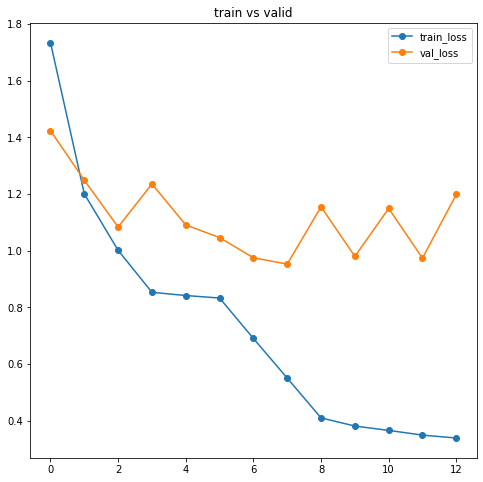

In [ ]:
# train , val loss 시각화

plt_loss(train_loss, val_loss)

In [ ]:
predict(resnet, test_loader, device)

100%|██████████| 168/168 [50:25<00:00, 18.01s/it]


precsion ------> 0.71801
f1_score ------> 0.71751
3860 / 5389, Accuracy: 71.627%



In [ ]:
mobilenet_optimizer = optim.Adam(params = mobilenet.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.LambdaLR(mobilenet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                         last_epoch = -1, verbose = False)

train_loss, val_loss = train(mobilenet, mobilenet_optimizer, 20, scheduler, device)


------ 0 epoch -------



100%|██████████| 168/168 [00:18<00:00,  9.31it/s]



Train loss: 1.2915
Val Loss: 1.0493
precsion ------> 0.66704
f1_score ------> 0.66262
3586 / 5389, Accuracy: 66.543%

Validation loss decreased (inf --> 1.049318).
 Saving model ...


------ 1 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.40it/s]



Train loss: 0.9899
Val Loss: 0.9424
precsion ------> 0.70294
f1_score ------> 0.69914
3779 / 5389, Accuracy: 70.124%

Validation loss decreased (1.049318 --> 0.942379).
 Saving model ...


------ 2 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.36it/s]


Train loss: 0.8513
Val Loss: 0.9756
precsion ------> 0.69624
f1_score ------> 0.69042
3743 / 5389, Accuracy: 69.456%

EarlyStopping counter: 1 out of 5

------ 3 epoch -------




100%|██████████| 168/168 [00:17<00:00,  9.46it/s]


Train loss: 0.8520
Val Loss: 0.9834
precsion ------> 0.69829
f1_score ------> 0.69405
3754 / 5389, Accuracy: 69.660%

EarlyStopping counter: 2 out of 5

------ 4 epoch -------




100%|██████████| 168/168 [00:17<00:00,  9.38it/s]



Train loss: 0.8441
Val Loss: 0.8836
precsion ------> 0.71540
f1_score ------> 0.71516
3846 / 5389, Accuracy: 71.368%

Validation loss decreased (0.942379 --> 0.883593).
 Saving model ...


------ 5 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.02it/s]


Train loss: 0.7355
Val Loss: 0.8812
precsion ------> 0.72489
f1_score ------> 0.72404
3897 / 5389, Accuracy: 72.314%

Validation loss decreased (0.883593 --> 0.881173).
 Saving model ...


------ 6 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.15it/s]



Train loss: 0.6579
Val Loss: 0.8151
precsion ------> 0.74777
f1_score ------> 0.74556
4020 / 5389, Accuracy: 74.596%

Validation loss decreased (0.881173 --> 0.815111).
 Saving model ...


------ 7 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.21it/s]


Train loss: 0.5784
Val Loss: 0.8316
precsion ------> 0.75279
f1_score ------> 0.75279
4047 / 5389, Accuracy: 75.097%

EarlyStopping counter: 1 out of 5

------ 8 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.23it/s]


Train loss: 0.5488
Val Loss: 0.8274
precsion ------> 0.74833
f1_score ------> 0.74700
4023 / 5389, Accuracy: 74.652%

EarlyStopping counter: 2 out of 5

------ 9 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.27it/s]


Train loss: 0.5330
Val Loss: 0.8311
precsion ------> 0.75316
f1_score ------> 0.74994
4049 / 5389, Accuracy: 75.135%

EarlyStopping counter: 3 out of 5

------ 10 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.24it/s]



Train loss: 0.5170
Val Loss: 0.7962
precsion ------> 0.76246
f1_score ------> 0.76229
4099 / 5389, Accuracy: 76.062%

Validation loss decreased (0.815111 --> 0.796210).
 Saving model ...


------ 11 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.22it/s]



Train loss: 0.4407
Val Loss: 0.8005
precsion ------> 0.77065
f1_score ------> 0.77089
4143 / 5389, Accuracy: 76.879%

EarlyStopping counter: 1 out of 5

------ 12 epoch -------



100%|██████████| 168/168 [00:16<00:00,  9.92it/s]



Train loss: 0.4185
Val Loss: 0.8305
precsion ------> 0.75614
f1_score ------> 0.75283
4065 / 5389, Accuracy: 75.431%

EarlyStopping counter: 2 out of 5

------ 13 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.24it/s]


Train loss: 0.4044
Val Loss: 0.8367
precsion ------> 0.76023
f1_score ------> 0.75880
4087 / 5389, Accuracy: 75.840%

EarlyStopping counter: 3 out of 5

------ 14 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.28it/s]



Train loss: 0.3891
Val Loss: 0.8354
precsion ------> 0.75967
f1_score ------> 0.75987
4084 / 5389, Accuracy: 75.784%

EarlyStopping counter: 4 out of 5

------ 15 epoch -------



100%|██████████| 168/168 [00:16<00:00, 10.25it/s]


Train loss: 0.3820
Val Loss: 0.8687
precsion ------> 0.75391
f1_score ------> 0.75390
4053 / 5389, Accuracy: 75.209%

EarlyStopping counter: 5 out of 5
Early Stopping


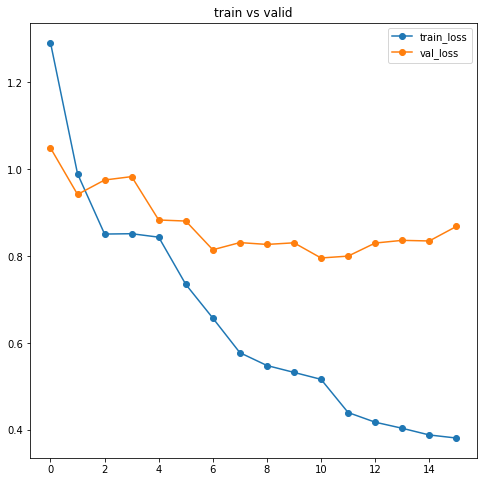

In [ ]:
# train , val loss 시각화

plt_loss(train_loss, val_loss)

In [ ]:
predict(mobilenet, test_loader, device)

100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


precsion ------> 0.76321
f1_score ------> 0.76510
4103 / 5389, Accuracy: 76.137%



In [ ]:
efficientnet_optimizer = optim.Adam(params = efficientnet.parameters(), lr = 0.001)
efficientnet_scheduler = optim.lr_scheduler.LambdaLR(efficientnet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                                     last_epoch = -1, verbose = False)
    
train_loss, val_loss = train(efficientnet, efficientnet_optimizer, 20, efficientnet_scheduler, device)


------ 0 epoch -------



100%|██████████| 168/168 [00:16<00:00,  9.94it/s]



Train loss: 1.0845
Val Loss: 0.8822
precsion ------> 0.72061
f1_score ------> 0.71951
3874 / 5389, Accuracy: 71.887%

Validation loss decreased (inf --> 0.882220).
 Saving model ...


------ 1 epoch -------



100%|██████████| 168/168 [00:19<00:00,  8.66it/s]



Train loss: 0.7046
Val Loss: 0.8269
precsion ------> 0.74163
f1_score ------> 0.74046
3987 / 5389, Accuracy: 73.984%

Validation loss decreased (0.882220 --> 0.826869).
 Saving model ...


------ 2 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.42it/s]



Train loss: 0.5431
Val Loss: 0.7843
precsion ------> 0.76190
f1_score ------> 0.76278
4096 / 5389, Accuracy: 76.007%

Validation loss decreased (0.826869 --> 0.784307).
 Saving model ...


------ 3 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.39it/s]


Train loss: 0.4108
Val Loss: 0.8750
precsion ------> 0.74665
f1_score ------> 0.74807
4014 / 5389, Accuracy: 74.485%

EarlyStopping counter: 1 out of 5

------ 4 epoch -------




100%|██████████| 168/168 [00:17<00:00,  9.63it/s]



Train loss: 0.3872
Val Loss: 0.7958
precsion ------> 0.77381
f1_score ------> 0.77139
4160 / 5389, Accuracy: 77.194%

EarlyStopping counter: 2 out of 5

------ 5 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.87it/s]



Train loss: 0.3728
Val Loss: 0.8116
precsion ------> 0.76339
f1_score ------> 0.76161
4104 / 5389, Accuracy: 76.155%

EarlyStopping counter: 3 out of 5

------ 6 epoch -------



100%|██████████| 168/168 [00:16<00:00,  9.98it/s]


Train loss: 0.3609
Val Loss: 0.8249
precsion ------> 0.75818
f1_score ------> 0.75963
4076 / 5389, Accuracy: 75.636%

EarlyStopping counter: 4 out of 5

------ 7 epoch -------




100%|██████████| 168/168 [00:16<00:00, 10.04it/s]



Train loss: 0.3462
Val Loss: 0.7702
precsion ------> 0.77586
f1_score ------> 0.77777
4171 / 5389, Accuracy: 77.398%

Validation loss decreased (0.784307 --> 0.770199).
 Saving model ...


------ 8 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.84it/s]



Train loss: 0.2341
Val Loss: 0.8804
precsion ------> 0.77381
f1_score ------> 0.77553
4160 / 5389, Accuracy: 77.194%

EarlyStopping counter: 1 out of 5

------ 9 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.65it/s]



Train loss: 0.2187
Val Loss: 0.8300
precsion ------> 0.78478
f1_score ------> 0.78506
4219 / 5389, Accuracy: 78.289%

EarlyStopping counter: 2 out of 5

------ 10 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.64it/s]



Train loss: 0.2098
Val Loss: 0.9002
precsion ------> 0.77623
f1_score ------> 0.77684
4173 / 5389, Accuracy: 77.436%

EarlyStopping counter: 3 out of 5

------ 11 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.77it/s]



Train loss: 0.2040
Val Loss: 0.8239
precsion ------> 0.78609
f1_score ------> 0.78836
4226 / 5389, Accuracy: 78.419%

EarlyStopping counter: 4 out of 5

------ 12 epoch -------



100%|██████████| 168/168 [00:17<00:00,  9.70it/s]


Train loss: 0.1914
Val Loss: 0.8571
precsion ------> 0.78367
f1_score ------> 0.78383
4213 / 5389, Accuracy: 78.178%

EarlyStopping counter: 5 out of 5
Early Stopping


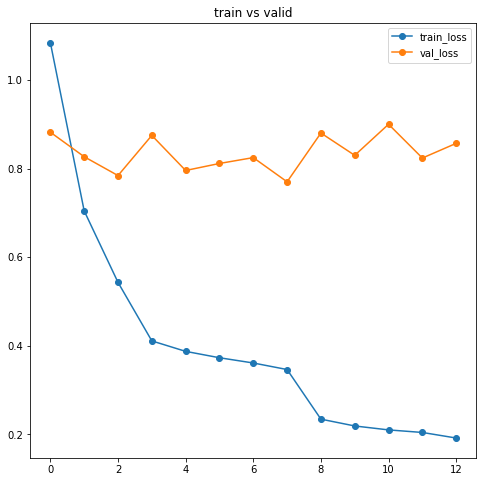

In [ ]:
# train , val loss 시각화

plt_loss(train_loss, val_loss)

In [ ]:
predict(efficientnet, test_loader, device)

100%|██████████| 168/168 [57:05<00:00, 20.39s/it]


precsion ------> 0.77102
f1_score ------> 0.77183
4145 / 5389, Accuracy: 76.916%



## 성능이 가장 좋았던 efficientnet을 통해 Grad-CAM 시각화 

### CAM이란?
> Global Average Pooling을 통해 특징을 히트맵으로 표현할 수 있는 XAI 기법

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbcw9hR%2FbtraXVOnnaK%2FDH0kgBq4ACELtwzSKBx1Bk%2Fimg.png" width=500, higth=500> 
>> 단점: Global average pooling을 사용하고 뒤에는 FC layer가 붙어있음

### Grad-CAM이란?

> GAP 사용 x, 픽셀의 변화량을 통해 표현하는 기법
>> 기존 CAM의 단점 보완

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcR0qoA%2FbtraVTXRJ14%2F6IRiTgdGvJ6yqSknHPkTkK%2Fimg.png" width=500, higth=500> 



In [ ]:
# 마지막 convolution layer
# 분류 부분 파라미터 추출

final_conv = efficientnet.model.features
fc_params = list(efficientnet.model.classifier.fc.parameters())
print(final_conv)
print("fc_params:", fc_params)

Sequential(
  (conv): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(1280, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (activation): SiLU(inplace=True)
)
fc_params: [Parameter containing:
tensor([[ 0.0379, -0.0016,  0.0128,  ..., -0.0780, -0.0128, -0.0482],
        [-0.1057, -0.0776, -0.0599,  ...,  0.0207,  0.0282, -0.0157],
        [-0.0155,  0.0207, -0.0330,  ...,  0.0238, -0.0366,  0.0317],
        ...,
        [-0.1163, -0.1234, -0.0685,  ..., -0.0052,  0.0402, -0.0938],
        [-0.0094, -0.0567,  0.0810,  ..., -0.0029, -0.1117,  0.0629],
        [-0.0431,  0.0312,  0.0690,  ...,  0.0281, -0.1487,  0.0492]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0010, -0.0504,  0.0275,  0.1329, -0.0165,  0.0989,  0.0283, -0.0147,
        -0.0419, -0.0914, -0.0566, -0.0457, -0.0991, -0.0652, -0.0074,  0.0620,
        -0.0013, -0.0193, -0.0319, -0.0218,  0.0464,  0.0536,  0.0155,  0.

In [ ]:
class SaveFeatures():
    # 특징 추출 
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

def getCAM(activated_features, weight, nc, h, w, pred_idx, i):
    cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w))) 
    cam = cam[i, :].reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img
    
def plotGradCAM(model, final_conv, fc_params, 
                row=1, col=10, img_size=256, device='cpu', original=False):

    for param in model.parameters():
        param.requires_grad = False
    
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'), strict = False)
    model.to(device)

    model_pred = []
    true_labels = []
    cam_correct = []
    cam_incorrect = []

    correct = 0
    model.eval()

    # 마지막 layer의 특징 추출 
    activated_features = SaveFeatures(final_conv)

    weight = np.squeeze(fc_params[0].cpu().data.numpy()) # flatten
    
    fig = plt.figure(figsize = (30, 30))

    for img, label in tqdm(iter(test_loader)):
        img = img.float()/255.0
        output = model(img.to(device))
        pred_idx = output.to('cpu').numpy().argmax(1)
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))

        model_pred += output.argmax(1).detach().cpu().numpy().tolist()
        true_labels += label.detach().cpu().numpy().tolist()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()

        _, nc, h, w = activated_features.features.shape # chanel, height, width 언패킹
   
    # 히트맵 표현
    for i in range(10):
        heatmap = getCAM(activated_features, weight, nc, h, w, pred_idx, i)
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        ax.set_title('Label:%d, Predict:%d'% (label[i], pred_idx[i]), fontsize=14)
        plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.resize(heatmap, (256, 256), interpolation=cv2.INTER_LINEAR), alpha=0.3, cmap='jet')
        
    test_accuracy = 100 * correct / len(test_loader.dataset)
    precision = precision_score(true_labels, model_pred, average = 'micro')
    f1 = f1_score(true_labels, model_pred, average = "weighted")


    print(cur_images.shape)
    print(f"\nprecsion ------> {precision:.5f}")
    print(f"f1_score ------> {f1:.5f}")
    print(f"{correct} / {len(test_loader.dataset)}, Accuracy: {test_accuracy:.3f}%\n")
    plt.show()    

100%|██████████| 168/168 [03:45<00:00,  1.34s/it]


(32, 256, 256, 3)

precsion ------> 0.77102
f1_score ------> 0.77183
4145 / 5389, Accuracy: 76.916%



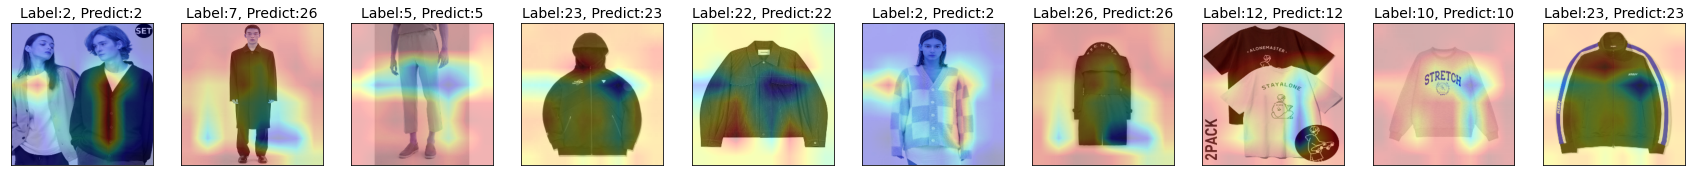

In [ ]:
# 히트맵을 보면 옷을 집중적으로 보기보다는
# 전체적으로 모든 곳을 중요하게 판단하거나
# 비슷한 곳을 위주로 보는 경향이 있다.

plotGradCAM(efficientnet, final_conv, fc_params, test_loader)

### 같은 클래스의 데이터라도 각각 다른 이미지들이 존재
### 성능 저하의 원인이라고 볼 수 있다.

<img src="https://image.msscdn.net/images/goods_img/20200831/1571500/1571500_9_500.jpg?t=20220804101205" width=300, higth=300>

<img src="https://image.msscdn.net/images/goods_img/20200922/1615829/1615829_1_500.jpg?t=20200922095758" width=300, higth=300>

<img src="https://image.msscdn.net/images/goods_img/20140115/70110/70110_10_500.jpg?t=20220628144518" width=300, higth=300>


## 결론 및 개선 사항
1. 해당 데이터에서 모델은 전체적으로 모든 곳을 보고 판단한다.
2. 데이터의 편향성을 줄이기 위한 변형이 필요할 것으로 보인다.
3. 코드에 대한 완벽한 이해 및 깔끔한 정리
